In [104]:
import pysam

In [105]:
fastq_path = "/Users/kimwilliame/Git/hiv/test_data/simbench_reads/simreads_R1.fastq"

mutation_rates = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

original_bam_path01 = "/Users/kimwilliame/Git/hiv/test_data/simbench/my_paired_reads/mr_"
original_bam_path02 = "/reads/simreads_R.sorted.bam"

bowtie2_bam_path01 = "/Users/kimwilliame/Git/hiv/test_out/bowtie2_alignments/Simbench/simreads_mr"
last_bam_path01 = "/Users/kimwilliame/Git/hiv/test_out/last_alignments/Simbench/simreads_mr"
last_trained_bam_path01 = "/Users/kimwilliame/Git/hiv/test_out/last_trained_alignments/Simbench/simreads_mr"

bam_path02 = "_to_haplotypes/paramgroup_1/alns.sorted.bam"

In [106]:
import pysam
import re

def get_actual_start_position(alignment):
    # Extract the POS (0-based in pysam) and CIGAR string
    pos = alignment.reference_start  # 0-based start position
    cigar = alignment.cigarstring
    
    # Check if there is soft clipping at the beginning
    soft_clip_start = 0
    if cigar.startswith('S'):
        match = re.match(r'^(\d+)S', cigar)
        if match:
            soft_clip_start = int(match.group(1))
    
    # Calculate the actual start position
    actual_start_position = pos - soft_clip_start

    print(actual_start_position, pos, soft_clip_start, cigar)
    
    return actual_start_position

def calculate_concordance(original_bam, aligned_bam):

    correctly_mapped = 0
    incorrectly_mapped = 0
    total_aligned = 0

    # Open BAM files
    original = pysam.AlignmentFile(original_bam, "rb")
    alignment = pysam.AlignmentFile(aligned_bam, "rb")

    # Create an index for the original BAM file
    original_index = pysam.IndexedReads(original)
    original_index.build()

    # Iterate through aligned 
    # haplotype0-18995
    for read in alignment:
        if read.is_unmapped:
            continue

        total_aligned += 1

        # Fetch corresponding read from reference using query_name
        reference_read = None
        try:
            for reference_read in original_index.find(read.query_name):
            # for reference_read in original_index.find("haplotype0-18995"):
                break
        except ValueError:
            pass

        # print(reference_read.query_name, aligned_read.query_name)
        if reference_read is None or reference_read.is_unmapped:
            incorrectly_mapped += 1
        elif abs(reference_read.reference_start - read.reference_start) <= 10:
            correctly_mapped += 1
        # elif abs(reference_read.reference_start - get_actual_start_position(aligned_read)) <= 10:
        #     correctly_mapped += 1
        else:
            incorrectly_mapped += 1

    # Close BAM files
    original.close()
    alignment.close()

    return correctly_mapped, incorrectly_mapped, total_aligned



In [107]:
# import pysam

# def calculate_concordance(original_bam, aligned_bam):

#     correctly_mapped = 0
#     incorrectly_mapped = 0
#     total_aligned = 0

#     # Open BAM files
#     original = pysam.AlignmentFile(original_bam, "rb")
#     aligned = pysam.AlignmentFile(aligned_bam, "rb")

#     # Create an index for the original BAM file
#     original_index = pysam.IndexedReads(original)
#     original_index.build()

#     aligned_index = pysam.IndexedReads(original)
#     aligned_index.build()

#     # Iterate through aligned 
#     # haplotype0-18995
#     reference_read = None
#     for aligned_read in aligned_index.find("haplotype0-18995"):
#         break
#     try:
#         # for reference_read in original_index.find(aligned_read.query_name):
#         for reference_read in original_index.find("haplotype0-18995"):
#             break
#     except ValueError:
#         pass

#     print(reference_read.get_reference_positions()[0], aligned_read.get_reference_positions()[0])

#     if reference_read is None:
#         incorrectly_mapped += 1
#     elif abs(reference_read.reference_start - aligned_read.reference_start) == 0:
#         correctly_mapped += 1
#     else:
#         aligned_pos = aligned_read.reference_start
#         op, length = aligned_read.cigartuples[0]
#         # if op == 0:
#         print(reference_read.reference_start, aligned_read.reference_start)
#         print(aligned_read.cigartuples)
#         for op, length in aligned_read.cigartuples:
#             print(aligned_pos, op, length)
#             # if op in [0, 2]:
#         incorrectly_mapped += 1

#     # Close BAM files
#     original.close()
#     aligned.close()

#     return correctly_mapped, total_aligned



In [108]:
import pandas as pd
results = []

# Calculate concordance with bowtie2_bam
for mr in mutation_rates:
    original_bam_path = original_bam_path01 + str(mr) + original_bam_path02
    bowtie2_bam_path = bowtie2_bam_path01 + str(mr) + bam_path02
    last_bam_path = last_bam_path01 + str(mr) + bam_path02
    last_trained_bam_path = last_trained_bam_path01 + str(mr) + bam_path02

    print(f"Mutation Rate: {mr}")

    bowtie2_concordance = calculate_concordance(original_bam_path, bowtie2_bam_path)
    results.append({
        "Aligner": "Bowtie2",
        "Correctly Mapped": bowtie2_concordance[0],
        "Percent Correctly Mapped": bowtie2_concordance[0] / bowtie2_concordance[2],
        "Incorrectly Mapped": bowtie2_concordance[1],
        "Percent Incorrectly Mapped": bowtie2_concordance[1] / bowtie2_concordance[2],
        "Total Aligned": bowtie2_concordance[2],
        "Mutation Rate": mr
    })

    print(f"Concordance with Bowtie2: {bowtie2_concordance[0]} out of {bowtie2_concordance[2]} aligned reads")

    # Calculate concordance with last_bam
    last_concordance = calculate_concordance(original_bam_path, last_bam_path)
    results.append({
        "Aligner": "Last",
        "Correctly Mapped": last_concordance[0],
        "Percent Correctly Mapped": last_concordance[0] / last_concordance[2],
        "Incorrectly Mapped": last_concordance[1],
        "Percent Incorrectly Mapped": last_concordance[1] / last_concordance[2],
        "Total Aligned": last_concordance[2],
        "Mutation Rate": mr
    })

    print(f"Concordance with Last: {last_concordance[0]} out of {last_concordance[2]} aligned reads")

    # Calculate concordance with last_trained_bam
    last_trained_concordance = calculate_concordance(original_bam_path, last_trained_bam_path)
    results.append({
        "Aligner": "Last Trained",
        "Correctly Mapped": last_trained_concordance[0],
        "Percent Correctly Mapped": last_trained_concordance[0] / last_trained_concordance[2],
        "Incorrectly Mapped": last_trained_concordance[1],
        "Percent Incorrectly Mapped": last_trained_concordance[1] / last_trained_concordance[2],
        "Total Aligned": last_trained_concordance[2],
        "Mutation Rate": mr
    })

    print(f"Concordance with Last Trained: {last_trained_concordance[0]} out of {last_trained_concordance[2]} aligned reads")

df = pd.DataFrame(results)  
print(df)

Mutation Rate: 0.05
Concordance with Bowtie2: 17989 out of 25143 aligned reads
Concordance with Last: 125275 out of 199613 aligned reads
Concordance with Last Trained: 266357 out of 281555 aligned reads
Mutation Rate: 0.1
Concordance with Bowtie2: 58 out of 25143 aligned reads
Concordance with Last: 439 out of 199613 aligned reads
Concordance with Last Trained: 548 out of 281555 aligned reads
Mutation Rate: 0.15
Concordance with Bowtie2: 53 out of 25143 aligned reads
Concordance with Last: 457 out of 199613 aligned reads
Concordance with Last Trained: 633 out of 281555 aligned reads
Mutation Rate: 0.2
Concordance with Bowtie2: 57 out of 25143 aligned reads
Concordance with Last: 446 out of 199613 aligned reads
Concordance with Last Trained: 594 out of 281555 aligned reads
Mutation Rate: 0.25
Concordance with Bowtie2: 55 out of 25143 aligned reads
Concordance with Last: 431 out of 199613 aligned reads
Concordance with Last Trained: 606 out of 281555 aligned reads
Mutation Rate: 0.3
Conc

In [109]:
df

,Aligner,Correctly Mapped,Percent Correctly Mapped,Incorrectly Mapped,Percent Incorrectly Mapped,Total Aligned,Mutation Rate
0,Bowtie2,17989,0.715468,7154,0.284532,25143,0.05
1,Last,125275,0.627589,74338,0.372411,199613,0.05
2,Last Trained,266357,0.946021,15198,0.053979,281555,0.05
3,Bowtie2,58,0.002307,25085,0.997693,25143,0.10
4,Last,439,0.002199,199174,0.997801,199613,0.10
5,Last Trained,548,0.001946,281007,0.998054,281555,0.10
6,Bowtie2,53,0.002108,25090,0.997892,25143,0.15
7,Last,457,0.002289,199156,0.997711,199613,0.15
8,Last Trained,633,0.002248,280922,0.997752,281555,0.15
9,Bowtie2,57,0.002267,25086,0.997733,25143,0.20


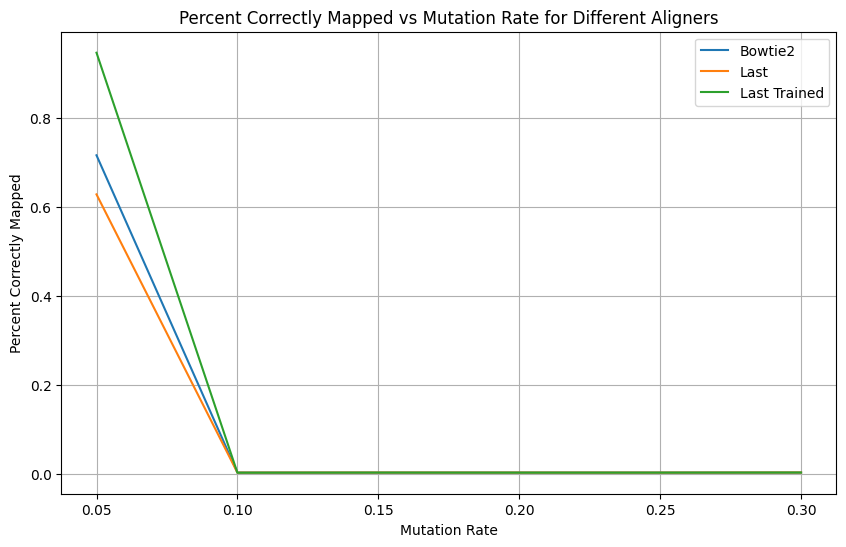

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for aligner in df['Aligner'].unique():
    aligner_df = df[df['Aligner'] == aligner]
    plt.plot(aligner_df['Mutation Rate'], aligner_df['Percent Correctly Mapped'], label=aligner)
    
plt.xlabel('Mutation Rate')
plt.ylabel('Percent Correctly Mapped')
plt.title('Percent Correctly Mapped vs Mutation Rate for Different Aligners')
plt.legend()
plt.grid(True)
plt.show()

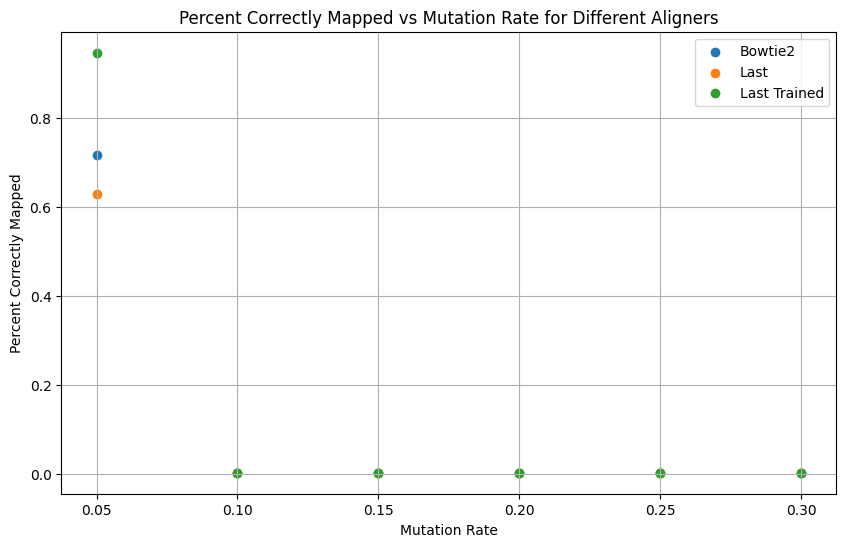

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for aligner in df['Aligner'].unique():
    subset = df[df['Aligner'] == aligner]
    plt.scatter(subset['Mutation Rate'], subset['Percent Correctly Mapped'], label=aligner)

plt.xlabel('Mutation Rate')
plt.ylabel('Percent Correctly Mapped')
plt.title('Percent Correctly Mapped vs Mutation Rate for Different Aligners')
plt.legend()
plt.grid(True)
plt.show()

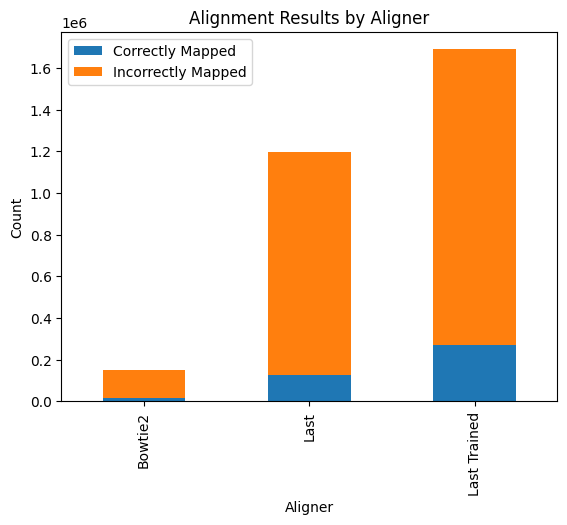

In [112]:
import matplotlib.pyplot as plt

# Assuming you have the DataFrame 'df' containing the results

# Group the results by aligner and sum the total aligned, correctly mapped, and incorrectly mapped reads
grouped_df = df.groupby('Aligner').sum()

# Plot stacked bar graph
grouped_df[['Correctly Mapped', 'Incorrectly Mapped']].plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Aligner')
plt.ylabel('Count')
plt.title('Alignment Results by Aligner')

# Show plot
plt.show()


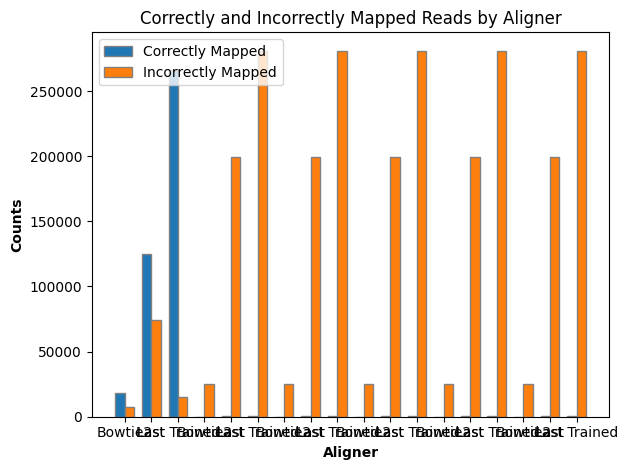

In [113]:
# Plotting
fig, ax = plt.subplots()

# Set position of bar on X axis
bar_width = 0.35
index = pd.RangeIndex(len(df['Aligner']))
r1 = index - bar_width/2
r2 = index + bar_width/2

# Make the plot
ax.bar(r1, df['Correctly Mapped'], width=bar_width, edgecolor='grey', label='Correctly Mapped')
ax.bar(r2, df['Incorrectly Mapped'], width=bar_width, edgecolor='grey', label='Incorrectly Mapped')

# Add xticks on the middle of the group bars
ax.set_xlabel('Aligner', fontweight='bold')
ax.set_xticks(index)
ax.set_xticklabels(df['Aligner'])
ax.set_ylabel('Counts', fontweight='bold')
ax.set_title('Correctly and Incorrectly Mapped Reads by Aligner')

# Create legend & Show graphic
ax.legend()
plt.tight_layout()

In [114]:
original_bam = pysam.AlignmentFile(original_bam_path, "rb")
bowtie2_bam = pysam.AlignmentFile(bowtie2_bam_path, "rb")
last_bam = pysam.AlignmentFile(last_bam_path, "rb")
last_trained_bam = pysam.AlignmentFile(last_trained_bam_path, "rb")

print(original_bam.mapped)
print(bowtie2_bam.mapped)
print(last_trained_bam.mapped)

print(original_bam.get_index_statistics())
print(bowtie2_bam.get_index_statistics())
print(last_trained_bam.get_index_statistics())


ValueError: mapping information not recorded in index or index not available

In [ ]:
# from pymsaviz import MsaViz

# path = "/Users/kimwilliame/Git/hiv/test_data/simbench_haplotypes/haplotypes_master.fasta"
# file = open(path, "r")
# mv = MsaViz(file, color_scheme="Taylor", wrap_length=80, show_grid=True, show_consensus=True)
# mv.savefig("api_example01.png")